# Assess Intervention Efficacy 

## Step 5 - Choose Baseline Variables to Collect (Data-driven approach using Group Lasso)
For interventions where only engagement data is available in the intervention arm. You will need a set of variables that are predictive of engagement level in the intervention arm in order to estimate the active user status of individuals in the control arm. At the **Design Stage** you need to consider the approach to choose these variables and ensure they are collected. 

In this case study example the trial had already been conducted so there was no control over these variables. So in order to identify which variables are predictive of engagement level in the intervention arm a group lasso model was used. The code to implement this is described below. 

In [1]:
# --------------------------------------------------
# Import Required Packages 
# --------------------------------------------------

import os 
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from celer import GroupLasso, GroupLassoCV, LassoCV, celer_path
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import Folders # Folder Directories for Data

In [2]:
import numpy as np
from celer import GroupLassoCV, LassoCV

import stata_setup
stata_setup.config('C:/Program Files/Stata17/', 'mp', splash=False) # splash=False # - if don't want the stata printout
from pystata import stata  

# --------------------------------------------------
# Run Preporcessing Step
# --------------------------------------------------

# Import Data to Pass to Python
stata.run('''
    qui do Folders
    qui cd "$ADAM"

    use ADSL, clear 
    merge 1:m ID using COPE_Final , nogen

    sort ID tptnum

    * --------------------------------------------------------
    * Generate Dummys
    * --------------------------------------------------------

    local dummy_prefix `" et em ed m d o t "'

    local z = 1
    foreach v in ethnic employ educate marry disease onset time {
        local dummy : word `z' of `dummy_prefix'
        local ++z
        
        levelsof `v', local(lvl)
        foreach x of local lvl {
            gen `dummy'`x' = (`v' == `x') , after(`v')
        }
    }

    * --------------------------------------------------------
    * Generate Dummys
    * --------------------------------------------------------

    keep if trt == 1 & tptnum == 1   
    drop if missing(gender, age, et1, et2, et3, et4, ///
        em1, em2, em3, em4, em5, em6, em7, ///
        ed1, ed2, ed3, ed4, ed5, ///
        m1, m2, m3, parent, living, ///
        gendercfp, d1, d2, ///
        o1, o2, o3, o4, o5, o6, o7, ///
        t1, t2, t3, t4, ///
        basew, basem, baseneg, basepos, basecw, basecs, basef, basevas, ///
        cluster)
          
''')

# Import Stata Dataframe to Pandas
df = stata.pdataframe_from_data()

# Array of Predictor Variables
predictors = ['gender', 'age', 'et1', 'et2',  'et3', 'et4', 
				'em1', 'em2', 'em3', 'em4', 'em5', 'em6', 'em7', 
				'ed1', 'ed2', 'ed3', 'ed4', 'ed5', 
				'm1', 'm2', 'm3', 'parent', 'living',
				'gendercfp', 'd1', 'd2', 
				'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 
				't1', 't2', 't3', 't4',	
				'basew', 'basem', 'baseneg', 'basepos', 'basecw', 'basecs', 'basef', 'basevas']

# ----------------------------------------------------
# Import Data
# ----------------------------------------------------

# Split in X and Y datasets 				
X = df[predictors].to_numpy()	

# Lasso explores both overall and for each Active User definition
Y = df['clusters'].to_numpy()
Y1 = df['ocomp1'].to_numpy()
Y2 = df['ocomp2'].to_numpy()
Y3 = df['ocomp3'].to_numpy()

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# ----------------------------------------------------
# Generate Groups 
# ----------------------------------------------------

def get_group(var):
    exact_map = {
        'gender': 0,
        'age': 1,
        'parent': 6,
        'living': 7,
        'gendercfp': 8,
        'basew': 12,
        'basem': 13,
        'baseneg': 14,
        'basepos': 15,
        'basecw': 16,
        'basecs': 17,
        'basef': 18,
        'basevas': 19
    }
    if var in exact_map:
        return exact_map[var]
    if var.startswith('et'):
        return 2
    elif var.startswith('em'):
        return 3
    elif var.startswith('ed'):
        return 4
    elif var.startswith('m'):
        return 5
    elif var.startswith('d'):
        return 9
    elif var.startswith('o'):
        return 10
    elif var.startswith('t'):
        return 11
    else:
        return -1

# ----------------------------------------------------
# Create Groups for Group Lasso
# ----------------------------------------------------

groups = np.array([get_group(var) for var in predictors])
print("Groups array:", groups)

unique_groups = np.unique(groups)
group_indices = []
for g in unique_groups:
    # Option: skip groups with label -1, if desired
    if g == -1:
        continue
    indices = [i for i, grp in enumerate(groups) if grp == g]
    # Only add if indices is not empty
    if indices:
        group_indices.append(indices)

print("Group indices:", group_indices)

# ----------------------------------------------------
# Names and Labels
# ----------------------------------------------------

# Varaible Labels (for graphs)
group_full_names = {
    0: "Gender",
    1: "Age",
    2: "Ethnicity",
    3: "Employment",
    4: "Education",
    5: "Marital Status",
    6: "Parent (y/n)",
    7: "Living with CfP",
    8: "Gender of CfP",
    9: "Disease",
    10: "Onset (years)",
    11: "Time Caring (hours)",
    12: "Baseline WEMWBS",
    13: "Baseline MAKS",
    14: "Baseline Negative ECI",
    15: "Baseline Positive ECI",
    16: "Baseline CW",
    17: "Baseline CS",
    18: "Baseline FQ",
    19: "Baseline VAS"
}

# Variable Names
group_names = {
    0: "gender",
    1: "age",
    2: "ethnic",
    3: "employ",
    4: "educate",
    5: "marry",
    6: "parent",
    7: "living",
    8: "gendercfp",
    9: "disease",
    10: "onset",
    11: "time",
    12: "basew",
    13: "basem",
    14: "baseneg",
    15: "basepos",
    16: "basecw",
    17: "basecs",
    18: "basef",
    19: "basevas"
}


. 
.     qui do Folders

.     qui cd "$ADAM"

. 
.     use ADSL, clear 

.     merge 1:m ID using COPE_Final , nogen
(variable ID was long, now double to accommodate using data's values)
(label sex already defined)
(label living already defined)

    Result                      Number of obs
    -----------------------------------------
    Not matched                            61
        from master                        61  
        from using                          0  

    Matched                             1,382  
    -----------------------------------------

. 
.     sort ID tptnum

. 
.     * --------------------------------------------------------
.     * Generate Dummys
.     * --------------------------------------------------------
. 
.     local dummy_prefix `" et em ed m d o t "'

. 
.     local z = 1

.     foreach v in ethnic employ educate marry disease onset time {
  2.         local dummy : word `z' of `dummy_prefix'
  3.         local ++z
  4.         
.     

Alpha max: 0.2505703442311215
Alphas range: 0.0002505703442311215 to 0.2505703442311215
Number of alphas tested: 100
Number of variables with zero importance: 0 / 45


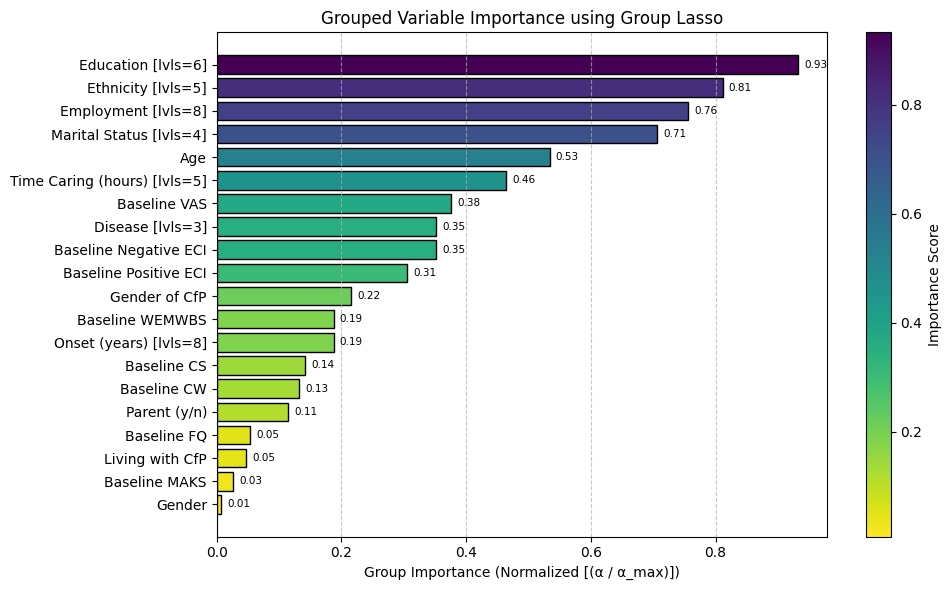

In [3]:
# --------------------------------------------------
# Scale the Data
# --------------------------------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True) ## With Mean to Centre Data aswell
X_scaled = scaler.fit_transform(X)  # Standardize features

# Convert the NumPy array back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# --------------------------------------------------
# Assess Variable Importance Across Alpha Range of Values
# --------------------------------------------------

# Compute alpha_max using Group Lasso
alphas, coefs, _ = celer_path(X_scaled, Y, pb="grouplasso", groups=group_indices)
alpha_max = max(alphas) 

# Print some info about alphas
print(f"Alpha max: {alpha_max}")
print(f"Alphas range: {alphas.min()} to {alphas.max()}")
print(f"Number of alphas tested: {len(alphas)}")

# Track when each coefficient drops to zero
importance_scores = np.zeros(len(predictors))

for i in range(len(predictors)):
    # Find the highest alpha where coef[i] is still nonzero
    nonzero_alphas = alphas[np.abs(coefs[i, :]) > 0]
    last_nonzero_alpha = np.max(nonzero_alphas) if nonzero_alphas.size > 0 else 0
    importance_scores[i] = last_nonzero_alpha

# Normalize scores so alpha_max corresponds to 1
importance_scores /= alpha_max  

# Check if any variables have zero importance
num_zero_importance = np.sum(importance_scores == 0)
print(f"Number of variables with zero importance: {num_zero_importance} / {len(predictors)}")

# Rescale coefficients to original feature scale
coefs_rescaled = coefs / scaler.scale_[:, None]

# --- Aggregate importance scores by group
# (For each group, take the maximum importance score among its predictors)
unique_groups = np.unique(groups[groups != -1])  # ignore -1 if any
group_scores = {}  # will hold the maximum score per group
group_counts = {}  # will count how many predictors per group

for g in unique_groups:
    idx = np.where(groups == g)[0]
    group_scores[g] = np.max(importance_scores[idx])
    group_counts[g] = len(idx)

# --- Create arrays for plotting, sorting groups by importance (descending)
group_ids = np.array(list(group_scores.keys()))
group_importance = np.array([group_scores[g] for g in group_ids])
sorted_order = np.argsort(group_importance)[::-1]
group_ids_sorted = group_ids[sorted_order]
group_importance_sorted = group_importance[sorted_order]

# --- Construct group labels
# For groups with more than one predictor (i.e. dummy variables), we add 1 to the count.
group_labels = []
for g in group_ids_sorted:
    count = group_counts[g]
    if count > 1:
        label = f"{group_full_names[g]} [lvls={count + 1}]"
    else:
        label = group_full_names[g]
    group_labels.append(label)

# Create a normalization object and reversed colormap so high importance is dark
norm = Normalize(vmin=group_importance_sorted.min(), vmax=group_importance_sorted.max())
cmap = plt.cm.viridis_r  # reversed so higher score → darker color
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(group_importance_sorted)
colors = cmap(norm(group_importance_sorted))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(group_labels, group_importance_sorted, color=colors, edgecolor='black')
ax.set_xlabel("Group Importance (Normalized [(α / α_max)])")
ax.set_title("Grouped Variable Importance using Group Lasso")
ax.invert_yaxis()  # Highest importance at the top
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Set x-axis limit to leave extra space for annotations
#ax.set_xlim(0, 1.01)

# Annotate each bar with its importance value
for bar, score in zip(bars, group_importance_sorted):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"{score:.2f}",
            va='center', ha='left', fontsize=7.5)

# Add colorbar (this acts as the legend for the gradient)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label("Importance Score")

plt.tight_layout()
plt.show()

In [4]:
# --------------------------------------------------
# Perform the Group Lasso with Cross-Validation
# --------------------------------------------------

print("Group Lasso - Using Cluster Variable")

model = GroupLassoCV(groups=group_indices, eps=0.001, n_alphas=100, 
                     fit_intercept=True, tol=0.0001, cv=10, verbose=0)
model.fit(X_scaled, Y)

# Print Model Parameters
print("Model intercept:", model.intercept_)
print("Model Alpha:", model.alpha_)

nonzero_indices = np.where(model.coef_ != 0)[0]
selected_predictors = [predictors[i] for i in nonzero_indices]
print("Selected Predictors:", selected_predictors)

# --------------------------------------------------
# Map to Original Variables to get proper names
# --------------------------------------------------

# Build a dictionary mapping group label -> list of selected dummy predictors
selected_groups = {}
for pred in selected_predictors:
    g = get_group(pred)
    if g == -1:  # Skip if group is not defined.
        continue
    if g not in selected_groups:
        selected_groups[g] = []
    selected_groups[g].append(pred)

# Now, build a list of "collapsed" group labels.
# For groups with more than one dummy, we add one to the count to represent the extra level.
original_variables = []
for g in sorted(selected_groups.keys()):
    full_name = group_names.get(g, f"Group {g}")
    count = len(selected_groups[g])
    if count > 1:
        label = f"{full_name}"
    else:
        label = full_name
    original_variables.append(label)

print("Original variable names for selected predictors:", original_variables) # Print Groups Selected

Group Lasso - Using Cluster Variable


C:\Users\je116\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The GroupLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Model intercept: 2.283333333333333
Model Alpha: 0.1917763600265379
Selected Predictors: ['et1', 'et2', 'et3', 'et4', 'em1', 'em2', 'em3', 'em4', 'em5', 'em6', 'em7', 'ed1', 'ed2', 'ed3', 'ed4', 'ed5']
Original variable names for selected predictors: ['ethnic', 'employ', 'educate']
